In [3]:
!wget  https://s3.us-east-2.amazonaws.com/audiosamplesyk/train.csv


Redirecting output to ‘wget-log.1’.


In [1]:
!wget https://s3.us-east-2.amazonaws.com/audiosamplesyk/test.csv


Redirecting output to ‘wget-log’.


In [2]:
!ls

sample_data  test.csv  wget-log


### Import Tensorflow library

In [5]:
import os
import sys
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model

Using TensorFlow backend.


#### Read the data set

In [0]:
df_train = pd.read_csv("train.csv")

df_test = pd.read_csv("test.csv")

#### Read head and tail of the data set

In [7]:
df_train.head(5)

,ID,categories,converse
0,2,ASK_A_DOCTOR,mom wants to know if the drugname needs some d...
1,3,ASK_A_DOCTOR,patients to discuss drugname she says she has ...
2,5,MISCELLANEOUS,letter of patient establishment request name s...
3,6,APPOINTMENTS,appointment question name mom appointments pat...
4,8,MISCELLANEOUS,please refax neurocog order to new wake medici...


In [8]:
df_test.tail(5)

,ID,converse
11450,57265,requesting drugname prior authorization be exp...
11451,57266,checking status of prior auth pain name patien...
11452,57269,lm for parent to cb to schedule rov with maure...
11453,57270,duragesic and drugname refill work phone patie...
11454,57275,patients wife would like a cb name spouse othe...


In [9]:
df_train.shape

(45825, 3)

In [10]:
df_test.shape

(11455, 2)

#### Check for structure and summary of the data set


In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45825 entries, 0 to 45824
Data columns (total 3 columns):
ID            45825 non-null int64
categories    45825 non-null object
converse      45796 non-null object
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


In [13]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11455 entries, 0 to 11454
Data columns (total 2 columns):
ID          11455 non-null int64
converse    11448 non-null object
dtypes: int64(1), object(1)
memory usage: 179.1+ KB


In [14]:
print(df_train.columns)
print('No. of unique classes',len(set(df_train['categories'])))

Index(['ID', 'categories', 'converse'], dtype='object')
No. of unique classes 6


In [15]:
df_train.categories.unique()

array(['ASK_A_DOCTOR', 'MISCELLANEOUS', 'APPOINTMENTS', 'LAB',
       'PRESCRIPTION', 'JUNK'], dtype=object)

#### Check for null value

In [16]:
df_train.isnull().sum()

ID             0
categories     0
converse      29
dtype: int64

In [17]:
df_test.isnull().sum()

ID          0
converse    7
dtype: int64

#### Check for the rows having null values

In [18]:
tr_nan_idx = df_train[pd.isnull(df_train['converse'])].index.tolist()

print(df_train.loc[tr_nan_idx])

          ID     categories converse
551      682  MISCELLANEOUS      NaN
2207    2749  MISCELLANEOUS      NaN
5328    6688           JUNK      NaN
9688   12086           JUNK      NaN
10195  12694   APPOINTMENTS      NaN
12782  15924           JUNK      NaN
12831  15996  MISCELLANEOUS      NaN
14144  17639           JUNK      NaN
14207  17721           JUNK      NaN
14767  18432           JUNK      NaN
15888  19830  MISCELLANEOUS      NaN
15905  19852  MISCELLANEOUS      NaN
19580  24492           JUNK      NaN
20678  25887           JUNK      NaN
20760  25991  MISCELLANEOUS      NaN
21474  26892  MISCELLANEOUS      NaN
22960  28731           JUNK      NaN
23029  28817           JUNK      NaN
24152  30198  MISCELLANEOUS      NaN
24407  30512  MISCELLANEOUS      NaN
27780  34727  MISCELLANEOUS      NaN
28106  35140  MISCELLANEOUS      NaN
29548  36966  MISCELLANEOUS      NaN
30219  37810  MISCELLANEOUS      NaN
30635  38328  MISCELLANEOUS      NaN
35446  44341  MISCELLANEOUS      NaN
3

In [19]:
ts_nan_idx = df_test[pd.isnull(df_test['converse'])].index.tolist()

print(df_test.loc[ts_nan_idx])

         ID converse
2811  14194      NaN
3603  18173      NaN
4447  22293      NaN
6261  31275      NaN
6737  33762      NaN
9539  47537      NaN
9702  48370      NaN


#### Replace NaN  value with White space

In [0]:
df_train.loc[tr_nan_idx, 'converse'] = ' '
df_test.loc[ts_nan_idx, 'converse'] = ' '

In [21]:
print(df_test.loc[ts_nan_idx])

         ID converse
2811  14194         
3603  18173         
4447  22293         
6261  31275         
6737  33762         
9539  47537         
9702  48370         


In [22]:
print(df_train.loc[tr_nan_idx])

          ID     categories converse
551      682  MISCELLANEOUS         
2207    2749  MISCELLANEOUS         
5328    6688           JUNK         
9688   12086           JUNK         
10195  12694   APPOINTMENTS         
12782  15924           JUNK         
12831  15996  MISCELLANEOUS         
14144  17639           JUNK         
14207  17721           JUNK         
14767  18432           JUNK         
15888  19830  MISCELLANEOUS         
15905  19852  MISCELLANEOUS         
19580  24492           JUNK         
20678  25887           JUNK         
20760  25991  MISCELLANEOUS         
21474  26892  MISCELLANEOUS         
22960  28731           JUNK         
23029  28817           JUNK         
24152  30198  MISCELLANEOUS         
24407  30512  MISCELLANEOUS         
27780  34727  MISCELLANEOUS         
28106  35140  MISCELLANEOUS         
29548  36966  MISCELLANEOUS         
30219  37810  MISCELLANEOUS         
30635  38328  MISCELLANEOUS         
35446  44341  MISCELLANEOUS         
3

#### Confirm for the exsistance of null values

In [23]:
df_train.isnull().sum()

ID            0
categories    0
converse      0
dtype: int64

In [24]:
df_test.isnull().sum()

ID          0
converse    0
dtype: int64

#### Assign multi class label to a numerical values

In [0]:
sort=sorted(set(df_train['categories']))
labels_index = dict((text, number) for text, number in enumerate(sort))

In [26]:
labels_index

{0: 'APPOINTMENTS',
 1: 'ASK_A_DOCTOR',
 2: 'JUNK',
 3: 'LAB',
 4: 'MISCELLANEOUS',
 5: 'PRESCRIPTION'}

In [0]:
texts = df_train.converse
labels = df_train.categories
ts_texts = df_test.converse

#### Text Preprocessing using by using keras

In [0]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
nb_epochs = 60

In [29]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
ts_sequences = tokenizer.texts_to_sequences(ts_texts)

word_index = tokenizer.word_index
print('Number of Unique Tokens',len(word_index))

Number of Unique Tokens 34769


In [0]:
# converts the character array to numeric array. Assigns levels to unique labels.
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()                 
le.fit(labels)
train_labels = le.transform(labels)

In [32]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
ts_data = pad_sequences(ts_sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(train_labels))
print('Shape of Data Tensor:', data.shape)
print('Shape of Label Tensor:', labels.shape)

Shape of Data Tensor: (45825, 1000)
Shape of Label Tensor: (45825, 6)


#### Splitting into train and test

In [0]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

#### Build index mapping words in the embeddings set to their embedding vector

#### Prepare embedding matrix

In [34]:
!wget https://s3.amazonaws.com/audiosampleyug/glove.6B.100d.txt 


Redirecting output to ‘wget-log.2’.


In [35]:
embeddings_index = {}
f = open('glove.6B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 400000 word vectors in Glove 6B 100d.


In [0]:
num_words = len(word_index) + 1
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,trainable=True)

#### 1D-CNN - GLOVE Vectors

In [37]:
print('Training model.')

# train a 1D convnet with global maxpooling
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(len(labels_index), activation='softmax')(x)

from keras.optimizers import Adam
adam = Adam(lr=0.001)
model1 = Model(sequence_input, preds)
model1.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['acc'])

print("Simple convolutional neural network")
model1.summary()
from keras.callbacks import ModelCheckpoint
cp=ModelCheckpoint('model_cnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)

Training model.
Simple convolutional neural network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         3477000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)       

In [38]:
model1_hist = model1.fit(x_train, y_train,
              batch_size=150,
              epochs=nb_epochs,
              validation_data=(x_val, y_val),callbacks=[cp])

Train on 36660 samples, validate on 9165 samples
Epoch 1/60
36660/36660 [==============================] - 26s 699us/step - loss: 0.8281 - acc: 0.6849 - val_loss: 0.5985 - val_acc: 0.7812

Epoch 00001: val_acc improved from -inf to 0.78123, saving model to model_cnn.hdf5
Epoch 2/60
36660/36660 [==============================] - 23s 636us/step - loss: 0.5231 - acc: 0.8094 - val_loss: 0.5219 - val_acc: 0.8092

Epoch 00002: val_acc improved from 0.78123 to 0.80917, saving model to model_cnn.hdf5
Epoch 3/60
36660/36660 [==============================] - 23s 636us/step - loss: 0.4423 - acc: 0.8383 - val_loss: 0.5174 - val_acc: 0.8083

Epoch 00003: val_acc did not improve from 0.80917
Epoch 4/60
36660/36660 [==============================] - 23s 637us/step - loss: 0.3833 - acc: 0.8599 - val_loss: 0.5073 - val_acc: 0.8143

Epoch 00004: val_acc improved from 0.80917 to 0.81429, saving model to model_cnn.hdf5
Epoch 5/60
36660/36660 [==============================] - 23s 638us/step - loss: 0.322

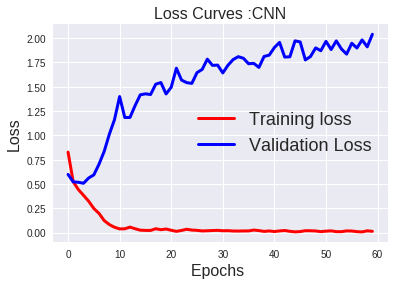

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

fig1 = plt.figure()
plt.plot(model1_hist.history['loss'],'r',linewidth=3.0)
plt.plot(model1_hist.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
fig1.savefig('loss_cnn.png')
plt.show()

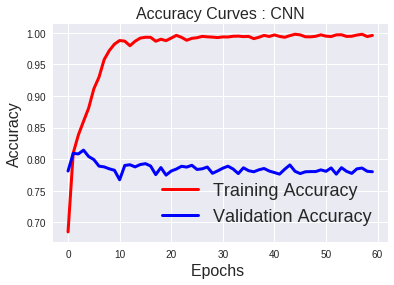

In [40]:
fig2=plt.figure()
plt.plot(model1_hist.history['acc'],'r',linewidth=3.0)
plt.plot(model1_hist.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig2.savefig('accuracy_cnn.png')
plt.show()

In [0]:
predict = model1.predict(ts_data)

In [0]:
test_classes = predict.argmax(axis=-1)

In [43]:
test_classes

array([5, 1, 1, ..., 5, 5, 1])

In [0]:
for x in range(0, test_classes.size):
  a = test_classes[x]
  categories.append(labels_index[a])

In [0]:
test_id = df_test['ID']

In [47]:
type(test_id)

pandas.core.series.Series

In [0]:
submission = pd.DataFrame({'ID':test_id, 'categories':categories})

In [0]:
submission.to_csv('mysubmission.csv', index= False)

In [50]:
!ls

accuracy_cnn.png   model_cnn.hdf5    test.csv	wget-log.1
glove.6B.100d.txt  mysubmission.csv  train.csv	wget-log.2
loss_cnn.png	   sample_data	     wget-log


In [0]:
from google.colab import files
files.download('mysubmission.csv')

#### LSTM - Glow Vector

In [54]:
from keras.layers import LSTM, Dropout
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
z = Dropout(0.2)(embedded_sequences)
z = LSTM(128)(z)
z = Dropout(0.4)(z)
preds_lstm = Dense(6, activation='softmax')(z)


from keras.optimizers import Adam
adam = Adam(lr=0.001)
model_lstm = Model(sequence_input, preds_lstm)
model_lstm.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['acc'])
print("Neural network using LSTM with Glow Vector")
model_lstm.summary()
cp=ModelCheckpoint('model_lstm.hdf5',monitor='val_acc',verbose=1,save_best_only=True)

Neural network using LSTM with Glow Vector
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         3477000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1000, 100)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 774       
Total params: 3,595,022
Trainable params: 3,595,022
Non-trainable params: 0
_______________________

In [55]:
model_lstm_hist = model_lstm.fit(x_train, y_train,
                  batch_size=128,
                  epochs=5,
                  validation_data=(x_val, y_val), callbacks=[cp])

Train on 36660 samples, validate on 9165 samples
Epoch 1/5
36660/36660 [==============================] - 761s 21ms/step - loss: 0.8704 - acc: 0.6855 - val_loss: 0.6786 - val_acc: 0.7720

Epoch 00001: val_acc improved from -inf to 0.77196, saving model to model_lstm.hdf5
Epoch 2/5
36660/36660 [==============================] - 759s 21ms/step - loss: 0.5803 - acc: 0.8045 - val_loss: 0.6083 - val_acc: 0.7792

Epoch 00002: val_acc improved from 0.77196 to 0.77916, saving model to model_lstm.hdf5
Epoch 3/5
36660/36660 [==============================] - 758s 21ms/step - loss: 0.4948 - acc: 0.8298 - val_loss: 0.6190 - val_acc: 0.7835

Epoch 00003: val_acc improved from 0.77916 to 0.78352, saving model to model_lstm.hdf5
Epoch 4/5
36660/36660 [==============================] - 755s 21ms/step - loss: 0.4301 - acc: 0.8471 - val_loss: 0.5654 - val_acc: 0.8052

Epoch 00004: val_acc improved from 0.78352 to 0.80524, saving model to model_lstm.hdf5
Epoch 5/5
36660/36660 [===========================

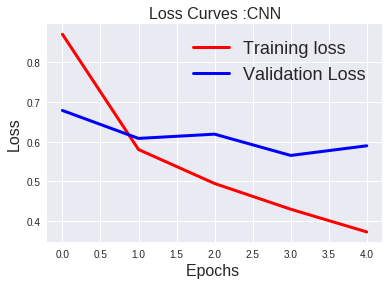

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline

fig1 = plt.figure()
plt.plot(model_lstm_hist.history['loss'],'r',linewidth=3.0)
plt.plot(model_lstm_hist.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
fig1.savefig('loss_cnn1.png')
plt.show()

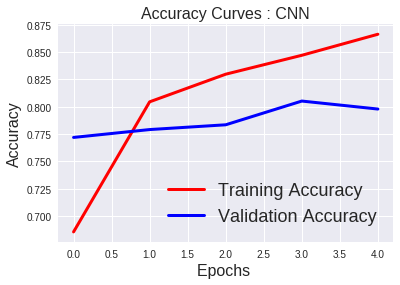

In [57]:
fig2=plt.figure()
plt.plot(model_lstm_hist.history['acc'],'r',linewidth=3.0)
plt.plot(model_lstm_hist.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig2.savefig('accuracy_cnn1.png')
plt.show()

In [0]:
predict = model_lstm.predict(ts_data)

In [0]:
test_classes = predict.argmax(axis=-1)

In [0]:
for x in range(0, test_classes.size):
  a = test_classes[x]
  categories.append(labels_index[a])

In [0]:
test_id1 = df_test['ID']

In [0]:
submission = pd.DataFrame({'ID':test_id1, 'categories':categories})

In [0]:
submission.to_csv('mysubmission1.csv', index= False)

In [0]:
!ls

In [0]:
from google.colab import files
files.download('mysubmission1.csv')